In [1]:
!pip install timm

# Import libraries

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, label_binarize
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.optim as optim
import torchvision.models as models
import time
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score
import seaborn as sns
from itertools import cycle
from collections import Counter
import timm

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

# Set Seeds for Reproducibility

In [3]:
import random

# Set seeds for reproducibility
SEED = 42

# Python random
random.seed(SEED)

# Numpy
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU

# PyTorch backend
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"Seeds set to {SEED} for reproducibility")

Seeds set to 42 for reproducibility


# Data Transformation

In [4]:
# ImageNet normalization constants
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Training transformations with data augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(
        size=224,
        scale=(0.9, 1.0),
        ratio=(0.95, 1.05)
    ),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(
        brightness=0.1,
        contrast=0.1,
        saturation=0.05,
        hue=0.02
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=IMAGENET_MEAN,
        std=IMAGENET_STD
    )
])

# Validation and test transformations without augmentation
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=IMAGENET_MEAN,
        std=IMAGENET_STD
    )
])

# Dataset

In [5]:
BATCH_SIZE = 16
NUM_WORKERS = 4

class BladderTissueDataset(Dataset):
    def __init__(self, dataframe, transform=None, label_encoder=None, fit_label_encoder=False):
        """
        Args:
            dataframe (DataFrame): DataFrame with HLY (image paths) and tissue type (labels) columns.
            transform (callable, optional): Optional transform to be applied on a sample.
            label_encoder (LabelEncoder, optional): Pre-fitted label encoder. If None, creates new one.
            fit_label_encoder (bool): Whether to fit the label encoder on this dataset's labels.
        """
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        
        if label_encoder is None:
            self.label_encoder = LabelEncoder()
            if fit_label_encoder:
                self.labels = self.label_encoder.fit_transform(self.data['tissue type'])
            else:
                raise ValueError("Must provide label_encoder or set fit_label_encoder=True")
        else:
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform(self.data['tissue type'])
        
        self.image_paths = self.data['HLY'].tolist()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Load image
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image: {img_path}")
            image = Image.new('RGB', (224, 224), color='black')
        
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)
    
    def get_label_encoder(self):
        """Return the label encoder for use with other datasets"""
        return self.label_encoder
    
    def get_class_names(self):
        """Return the original class names"""
        return self.label_encoder.classes_

In [6]:
# Create datasets from DataFrames
def create_datasets_from_dataframes(train_df, val_df, test_df):
    """
    Create train, validation, and test datasets with proper label encoding
    """
    # Create training dataset and fit label encoder
    train_dataset = BladderTissueDataset(
        dataframe=train_df, 
        transform=train_transform,
        fit_label_encoder=True  
    )
    
    # Get the fitted label encoder
    le = train_dataset.get_label_encoder()
    
    # Create validation dataset using the same label encoder
    val_dataset = BladderTissueDataset(
        dataframe=val_df,
        transform=val_test_transform,
        label_encoder=le
    )
    
    # Create test dataset using the same label encoder
    test_dataset = BladderTissueDataset(
        dataframe=test_df,
        transform=val_test_transform,
        label_encoder=le
    )
    
    return train_dataset, val_dataset, test_dataset, le

# Dataloader

In [7]:
# Create dataloaders
def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    """
    Create dataloaders for training, validation, and testing
    """
    # Worker seed for reproducibility
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)
    
    g = torch.Generator()
    g.manual_seed(42)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
        worker_init_fn=seed_worker,
        generator=g
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        worker_init_fn=seed_worker,    
        generator=g    
    )

    test_loader = DataLoader(
        test_dataset,
        pin_memory=True,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        worker_init_fn=seed_worker,
        generator=g
    )
    return train_loader, val_loader, test_loader

In [8]:
train_df = pd.read_csv("/kaggle/input/ebt-dataset/train.csv")
test_df = pd.read_csv("/kaggle/input/ebt-dataset/test.csv")
valid_df = pd.read_csv("/kaggle/input/ebt-dataset/valid.csv")

In [9]:
train_dataset, val_dataset, test_dataset, label_encoder = create_datasets_from_dataframes(
    train_df, valid_df, test_df
)

train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset, val_dataset, test_dataset, 
    batch_size=32, 
    num_workers=4
)

# Utility Functions

In [10]:
def compute_class_weights(train_loader, num_classes):
    """Compute class weights for handling imbalanced datasets"""
    class_counts = Counter()

    for _, labels in train_loader:
        class_counts.update(labels.numpy())

    total_samples = sum(class_counts.values())

    weights = []
    for i in range(num_classes):
        weights.append(total_samples / (num_classes * class_counts[i]))

    return torch.tensor(weights, dtype=torch.float)

# Model Training Framework

In [11]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, test_loader, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        
        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def train_model(self, num_epochs=25, lr=0.001, weight_decay=1e-4, save_best=True, model_name="model"):
        """Train the model with early stopping and best model saving based on macro-F1"""
        
        # Loss function and optimizer
        class_weights = compute_class_weights(self.train_loader, num_classes=len(self.train_loader.dataset.get_label_encoder().classes_))
        class_weights = class_weights.to(self.device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        
        # Best model tracking
        best_val_f1 = 0.0
        best_model_wts = copy.deepcopy(self.model.state_dict())
        patience = 5
        patience_counter = 0
        
        print(f"Starting training for {num_epochs} epochs...")
        print("-" * 60)
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                    dataloader = self.train_loader
                else:
                    self.model.eval()
                    dataloader = self.val_loader
                
                running_loss = 0.0
                running_corrects = 0
                total_samples = 0
                all_preds = []
                all_labels = []
                
                # Progress bar
                pbar = tqdm(dataloader, desc=f'{phase.capitalize()} ')
                
                for inputs, labels in pbar:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    
                    # Zero gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # Backward pass (only in training)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += inputs.size(0)
                    
                    # Store predictions and labels for F1 calculation
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    
                    # Update progress bar
                    current_acc = running_corrects.double() / total_samples
                    pbar.set_postfix({
                        'Loss': f'{running_loss/total_samples:.4f}',
                        'Acc': f'{current_acc:.4f}'
                    })
                
                # Calculate epoch metrics
                epoch_loss = running_loss / total_samples
                epoch_acc = running_corrects.double() / total_samples
                epoch_f1 = f1_score(all_labels, all_preds, average='macro')
                
                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Macro-F1: {epoch_f1:.4f}')
                
                # Store metrics
                if phase == 'train':
                    self.train_losses.append(epoch_loss)
                    self.train_accuracies.append(epoch_acc.cpu())
                else:
                    self.val_losses.append(epoch_loss)
                    self.val_accuracies.append(epoch_acc.cpu())
                
                # Save best model based on validation macro-F1
                if phase == 'val' and epoch_f1 > best_val_f1:
                    best_val_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(self.model.state_dict())
                    patience_counter = 0
                    if save_best:
                        torch.save(self.model.state_dict(), f'best_{model_name}.pth')
                        print(f'✓ New best model saved with validation macro-F1: {best_val_f1:.4f}')
                elif phase == 'val':
                    patience_counter += 1
            
            # Learning rate scheduler step (after both train and val phases)
            scheduler.step()
            
            # Early stopping
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
                
            print()
        
        # Training complete
        time_elapsed = time.time() - start_time
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best validation macro-F1: {best_val_f1:.4f}')
        
        # Load best model weights
        self.model.load_state_dict(best_model_wts)
        return self.model
    
    def evaluate_model(self, test_loader=None, class_names=['HGC', 'LGC', 'NST', 'NTL']):
        """Evaluate model on test set and return all metrics"""
        if test_loader is None:
            test_loader = self.test_loader
            
        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        test_loss = 0.0
        correct = 0
        total = 0
        
        criterion = nn.CrossEntropyLoss()
        
        print("Evaluating on test set...")
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self.model(inputs)
                probs = torch.softmax(outputs, dim=1)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss += loss.item() * inputs.size(0)
                
                # Store for detailed metrics
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        # Calculate metrics
        test_acc = 100 * correct / total
        avg_test_loss = test_loss / total
        
        print(f'Test Accuracy: {test_acc:.2f}%')
        print(f'Test Loss: {avg_test_loss:.4f}')
        
        # Detailed classification report
        print("\nClassification Report:")
        report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
        print(classification_report(all_labels, all_preds, target_names=class_names))
        
        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print(f"\nConfusion Matrix:")
        print(cm)
        
        # Compute ROC-AUC scores
        labels_bin = label_binarize(all_labels, classes=list(range(len(class_names))))
        probs_array = np.array(all_probs)
        
        # Per-class ROC-AUC
        per_class_auc = {}
        for i, class_name in enumerate(class_names):
            try:
                per_class_auc[class_name] = roc_auc_score(labels_bin[:, i], probs_array[:, i])
            except:
                per_class_auc[class_name] = 0.0
        
        # Macro ROC-AUC (average of per-class AUCs)
        macro_auc = np.mean(list(per_class_auc.values()))
        
        # Micro ROC-AUC (using all predictions)
        try:
            micro_auc = roc_auc_score(labels_bin.ravel(), probs_array.ravel())
        except:
            micro_auc = 0.0
        
        print(f"\nROC-AUC Scores:")
        print(f"Macro-average AUC: {macro_auc:.4f}")
        print(f"Micro-average AUC: {micro_auc:.4f}")
        for class_name, auc_score in per_class_auc.items():
            print(f"{class_name} AUC: {auc_score:.4f}")
        
        return {
            'accuracy': test_acc,
            'loss': avg_test_loss,
            'predictions': all_preds,
            'labels': all_labels,
            'probabilities': all_probs,
            'confusion_matrix': cm,
            'classification_report': report,
            'per_class_auc': per_class_auc,
            'macro_auc': macro_auc,
            'micro_auc': micro_auc
        }
    
    def plot_training_history(self, save_path=None):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(self.train_losses, label='Train Loss', marker='o')
        ax1.plot(self.val_losses, label='Validation Loss', marker='s')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracies
        ax2.plot(self.train_accuracies, label='Train Accuracy', marker='o')
        ax2.plot(self.val_accuracies, label='Validation Accuracy', marker='s')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        plt.show()

# Model Definitions

In [12]:
def create_mvit_model(architecture='mvitv2_tiny', num_classes=4, pretrained=True):
    """Create MViT v2 (Multiscale Vision Transformer) model for multi-class classification"""
    if architecture == 'mvitv2_tiny':
        model = timm.create_model('mvitv2_tiny', pretrained=pretrained, num_classes=num_classes)
    elif architecture == 'mvitv2_small':
        model = timm.create_model('mvitv2_small', pretrained=pretrained, num_classes=num_classes)
    elif architecture == 'mvitv2_base':
        model = timm.create_model('mvitv2_base', pretrained=pretrained, num_classes=num_classes)
    else:
        raise ValueError("Architecture must be 'mvitv2_tiny', 'mvitv2_small', or 'mvitv2_base'")
    
    return model

# Configure GPU

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Visualization Functions

In [14]:
def plot_confusion_matrix(cm, class_names, model_name, save_path=None):
    """Plot confusion matrix with nice formatting"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_curves(labels, probs, class_names, model_name, save_path=None):
    """Plot ROC curves for multi-class classification"""
    # Binarize the labels
    n_classes = len(class_names)
    labels_bin = label_binarize(labels, classes=list(range(n_classes)))
    probs_array = np.array(probs)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], probs_array[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_bin.ravel(), probs_array.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curves
    plt.figure(figsize=(12, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=3,
             label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves - {model_name}', fontsize=16, pad=20)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return roc_auc

# Train and Evaluate Models

In [15]:
# Get class names from label encoder
class_names = list(label_encoder.classes_)
print(f"Classes: {class_names}")

# Store results for all models
all_results = []

Classes: ['HGC', 'LGC', 'NST', 'NTL']


## Train MViT v2 Tiny

Training MViT v2 Tiny


model.safetensors:   0%|          | 0.00/96.7M [00:00<?, ?B/s]

Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:15<00:00,  2.40it/s, Loss=1.3086, Acc=0.4679]


Train Loss: 1.3086 Acc: 0.4679 Macro-F1: 0.3995


Val : 100%|██████████| 10/10 [00:01<00:00,  5.87it/s, Loss=1.1301, Acc=0.3816]


Val Loss: 1.1301 Acc: 0.3816 Macro-F1: 0.3131
✓ New best model saved with validation macro-F1: 0.3131

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:14<00:00,  2.67it/s, Loss=1.0175, Acc=0.5905]


Train Loss: 1.0175 Acc: 0.5905 Macro-F1: 0.5300


Val : 100%|██████████| 10/10 [00:01<00:00,  6.59it/s, Loss=0.9252, Acc=0.6217]


Val Loss: 0.9252 Acc: 0.6217 Macro-F1: 0.5727
✓ New best model saved with validation macro-F1: 0.5727

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:14<00:00,  2.67it/s, Loss=0.8876, Acc=0.6957]


Train Loss: 0.8876 Acc: 0.6957 Macro-F1: 0.6183


Val : 100%|██████████| 10/10 [00:01<00:00,  6.37it/s, Loss=0.7821, Acc=0.7138]


Val Loss: 0.7821 Acc: 0.7138 Macro-F1: 0.6587
✓ New best model saved with validation macro-F1: 0.6587

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:14<00:00,  2.66it/s, Loss=0.8042, Acc=0.7007]


Train Loss: 0.8042 Acc: 0.7007 Macro-F1: 0.6411


Val : 100%|██████████| 10/10 [00:01<00:00,  6.46it/s, Loss=0.5674, Acc=0.8224]


Val Loss: 0.5674 Acc: 0.8224 Macro-F1: 0.7957
✓ New best model saved with validation macro-F1: 0.7957

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:14<00:00,  2.66it/s, Loss=0.7174, Acc=0.7278]


Train Loss: 0.7174 Acc: 0.7278 Macro-F1: 0.6733


Val : 100%|██████████| 10/10 [00:01<00:00,  6.43it/s, Loss=0.8660, Acc=0.6151]


Val Loss: 0.8660 Acc: 0.6151 Macro-F1: 0.5589

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:14<00:00,  2.66it/s, Loss=0.6546, Acc=0.7689]


Train Loss: 0.6546 Acc: 0.7689 Macro-F1: 0.7179


Val : 100%|██████████| 10/10 [00:01<00:00,  6.47it/s, Loss=0.4598, Acc=0.8059]


Val Loss: 0.4598 Acc: 0.8059 Macro-F1: 0.7667

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:14<00:00,  2.67it/s, Loss=0.6603, Acc=0.7327]


Train Loss: 0.6603 Acc: 0.7327 Macro-F1: 0.6871


Val : 100%|██████████| 10/10 [00:01<00:00,  6.46it/s, Loss=0.8398, Acc=0.7401]


Val Loss: 0.8398 Acc: 0.7401 Macro-F1: 0.6994

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:14<00:00,  2.66it/s, Loss=0.5320, Acc=0.8117]


Train Loss: 0.5320 Acc: 0.8117 Macro-F1: 0.7644


Val : 100%|██████████| 10/10 [00:01<00:00,  6.46it/s, Loss=0.3638, Acc=0.8651]


Val Loss: 0.3638 Acc: 0.8651 Macro-F1: 0.8252
✓ New best model saved with validation macro-F1: 0.8252

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:14<00:00,  2.66it/s, Loss=0.3480, Acc=0.8734]


Train Loss: 0.3480 Acc: 0.8734 Macro-F1: 0.8333


Val : 100%|██████████| 10/10 [00:01<00:00,  6.42it/s, Loss=0.2922, Acc=0.8882]


Val Loss: 0.2922 Acc: 0.8882 Macro-F1: 0.8597
✓ New best model saved with validation macro-F1: 0.8597

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:14<00:00,  2.66it/s, Loss=0.2871, Acc=0.9054]


Train Loss: 0.2871 Acc: 0.9054 Macro-F1: 0.8847


Val : 100%|██████████| 10/10 [00:01<00:00,  6.48it/s, Loss=0.2249, Acc=0.9178]


Val Loss: 0.2249 Acc: 0.9178 Macro-F1: 0.9075
✓ New best model saved with validation macro-F1: 0.9075

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:14<00:00,  2.67it/s, Loss=0.2230, Acc=0.9285]


Train Loss: 0.2230 Acc: 0.9285 Macro-F1: 0.9114


Val : 100%|██████████| 10/10 [00:01<00:00,  6.57it/s, Loss=0.2636, Acc=0.8849]


Val Loss: 0.2636 Acc: 0.8849 Macro-F1: 0.8465

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:14<00:00,  2.66it/s, Loss=0.1939, Acc=0.9342]


Train Loss: 0.1939 Acc: 0.9342 Macro-F1: 0.9245


Val : 100%|██████████| 10/10 [00:01<00:00,  6.55it/s, Loss=0.1610, Acc=0.9309]


Val Loss: 0.1610 Acc: 0.9309 Macro-F1: 0.9083
✓ New best model saved with validation macro-F1: 0.9083

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:14<00:00,  2.66it/s, Loss=0.1534, Acc=0.9465]


Train Loss: 0.1534 Acc: 0.9465 Macro-F1: 0.9321


Val : 100%|██████████| 10/10 [00:01<00:00,  6.36it/s, Loss=0.1867, Acc=0.9309]


Val Loss: 0.1867 Acc: 0.9309 Macro-F1: 0.9056

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:14<00:00,  2.67it/s, Loss=0.1259, Acc=0.9556]


Train Loss: 0.1259 Acc: 0.9556 Macro-F1: 0.9422


Val : 100%|██████████| 10/10 [00:01<00:00,  6.34it/s, Loss=0.0907, Acc=0.9671]


Val Loss: 0.0907 Acc: 0.9671 Macro-F1: 0.9486
✓ New best model saved with validation macro-F1: 0.9486

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:14<00:00,  2.66it/s, Loss=0.0952, Acc=0.9663]


Train Loss: 0.0952 Acc: 0.9663 Macro-F1: 0.9591


Val : 100%|██████████| 10/10 [00:01<00:00,  6.45it/s, Loss=0.0951, Acc=0.9671]


Val Loss: 0.0951 Acc: 0.9671 Macro-F1: 0.9559
✓ New best model saved with validation macro-F1: 0.9559

Epoch 16/25
----------


Train : 100%|██████████| 38/38 [00:14<00:00,  2.67it/s, Loss=0.0833, Acc=0.9745]


Train Loss: 0.0833 Acc: 0.9745 Macro-F1: 0.9670


Val : 100%|██████████| 10/10 [00:01<00:00,  6.48it/s, Loss=0.0903, Acc=0.9704]


Val Loss: 0.0903 Acc: 0.9704 Macro-F1: 0.9585
✓ New best model saved with validation macro-F1: 0.9585

Epoch 17/25
----------


Train : 100%|██████████| 38/38 [00:14<00:00,  2.67it/s, Loss=0.0803, Acc=0.9762]


Train Loss: 0.0803 Acc: 0.9762 Macro-F1: 0.9672


Val : 100%|██████████| 10/10 [00:01<00:00,  6.57it/s, Loss=0.0878, Acc=0.9704]


Val Loss: 0.0878 Acc: 0.9704 Macro-F1: 0.9585

Epoch 18/25
----------


Train : 100%|██████████| 38/38 [00:14<00:00,  2.66it/s, Loss=0.0739, Acc=0.9778]


Train Loss: 0.0739 Acc: 0.9778 Macro-F1: 0.9750


Val : 100%|██████████| 10/10 [00:01<00:00,  6.51it/s, Loss=0.0885, Acc=0.9704]


Val Loss: 0.0885 Acc: 0.9704 Macro-F1: 0.9585

Epoch 19/25
----------


Train : 100%|██████████| 38/38 [00:14<00:00,  2.66it/s, Loss=0.0708, Acc=0.9770]


Train Loss: 0.0708 Acc: 0.9770 Macro-F1: 0.9698


Val : 100%|██████████| 10/10 [00:01<00:00,  6.46it/s, Loss=0.0823, Acc=0.9671]


Val Loss: 0.0823 Acc: 0.9671 Macro-F1: 0.9559

Epoch 20/25
----------


Train : 100%|██████████| 38/38 [00:14<00:00,  2.66it/s, Loss=0.0645, Acc=0.9770]


Train Loss: 0.0645 Acc: 0.9770 Macro-F1: 0.9725


Val : 100%|██████████| 10/10 [00:01<00:00,  6.53it/s, Loss=0.0776, Acc=0.9671]


Val Loss: 0.0776 Acc: 0.9671 Macro-F1: 0.9559

Epoch 21/25
----------


Train : 100%|██████████| 38/38 [00:14<00:00,  2.65it/s, Loss=0.0641, Acc=0.9811]


Train Loss: 0.0641 Acc: 0.9811 Macro-F1: 0.9780


Val : 100%|██████████| 10/10 [00:01<00:00,  6.58it/s, Loss=0.0787, Acc=0.9770]


Val Loss: 0.0787 Acc: 0.9770 Macro-F1: 0.9680
✓ New best model saved with validation macro-F1: 0.9680

Epoch 22/25
----------


Train : 100%|██████████| 38/38 [00:14<00:00,  2.66it/s, Loss=0.0600, Acc=0.9794]


Train Loss: 0.0600 Acc: 0.9794 Macro-F1: 0.9719


Val : 100%|██████████| 10/10 [00:01<00:00,  6.47it/s, Loss=0.0780, Acc=0.9737]


Val Loss: 0.0780 Acc: 0.9737 Macro-F1: 0.9612

Epoch 23/25
----------


Train : 100%|██████████| 38/38 [00:14<00:00,  2.66it/s, Loss=0.0502, Acc=0.9868]


Train Loss: 0.0502 Acc: 0.9868 Macro-F1: 0.9827


Val : 100%|██████████| 10/10 [00:01<00:00,  6.55it/s, Loss=0.0780, Acc=0.9770]


Val Loss: 0.0780 Acc: 0.9770 Macro-F1: 0.9680

Epoch 24/25
----------


Train : 100%|██████████| 38/38 [00:14<00:00,  2.66it/s, Loss=0.0706, Acc=0.9762]


Train Loss: 0.0706 Acc: 0.9762 Macro-F1: 0.9705


Val : 100%|██████████| 10/10 [00:01<00:00,  6.47it/s, Loss=0.0780, Acc=0.9737]


Val Loss: 0.0780 Acc: 0.9737 Macro-F1: 0.9612

Epoch 25/25
----------


Train : 100%|██████████| 38/38 [00:14<00:00,  2.66it/s, Loss=0.0574, Acc=0.9844]


Train Loss: 0.0574 Acc: 0.9844 Macro-F1: 0.9819


Val : 100%|██████████| 10/10 [00:01<00:00,  6.40it/s, Loss=0.0781, Acc=0.9737]


Val Loss: 0.0781 Acc: 0.9737 Macro-F1: 0.9654

Training complete in 6m 40s
Best validation macro-F1: 0.9680


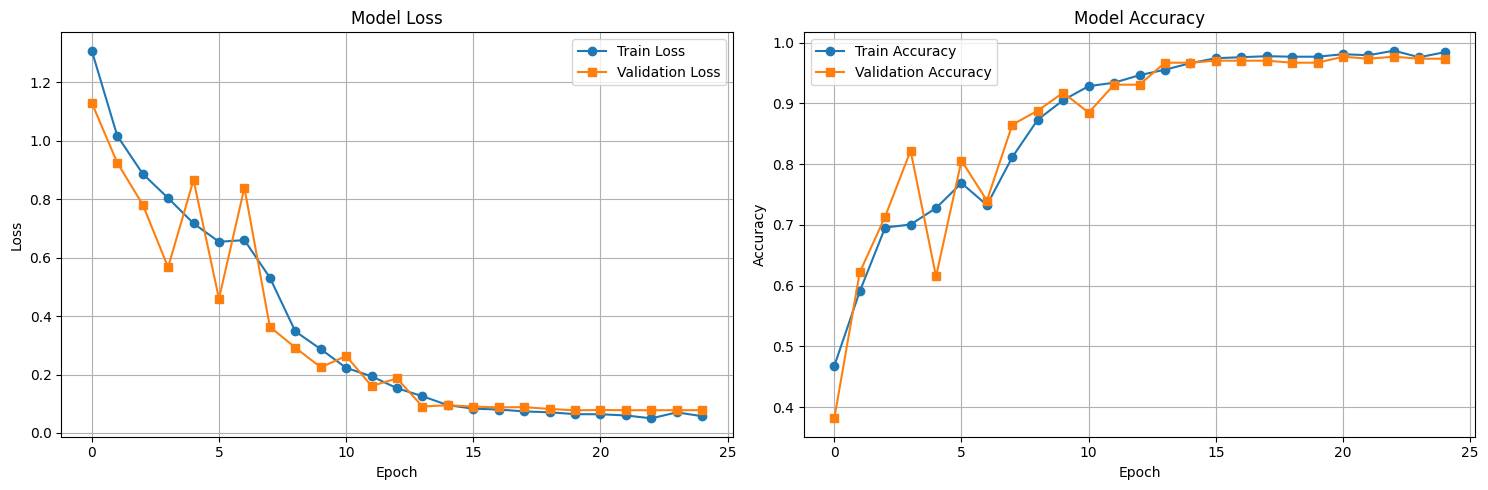

Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  4.67it/s]


Test Accuracy: 46.56%
Test Loss: 3.2022

Classification Report:
              precision    recall  f1-score   support

         HGC       0.86      0.42      0.56        74
         LGC       0.35      0.36      0.36        53
         NST       0.53      0.54      0.53        37
         NTL       0.30      0.72      0.42        25

    accuracy                           0.47       189
   macro avg       0.51      0.51      0.47       189
weighted avg       0.58      0.47      0.48       189


Confusion Matrix:
[[31 18 13 12]
 [ 2 19  5 27]
 [ 1 12 20  4]
 [ 2  5  0 18]]

ROC-AUC Scores:
Macro-average AUC: 0.6914
Micro-average AUC: 0.6888
HGC AUC: 0.6710
LGC AUC: 0.5470
NST AUC: 0.8551
NTL AUC: 0.6927


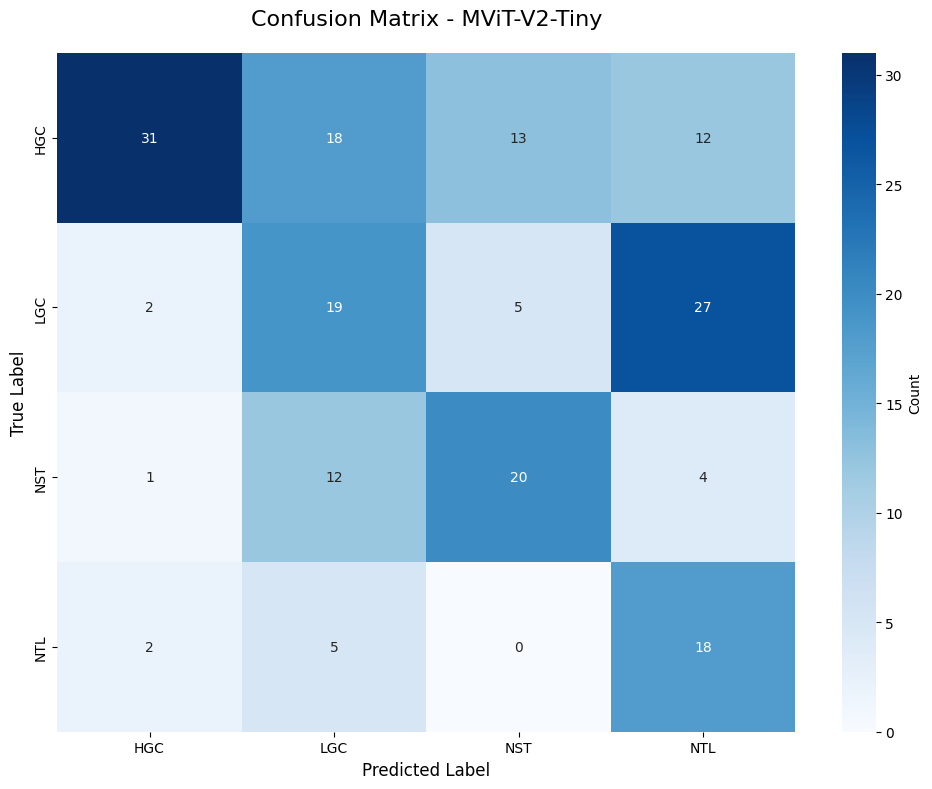

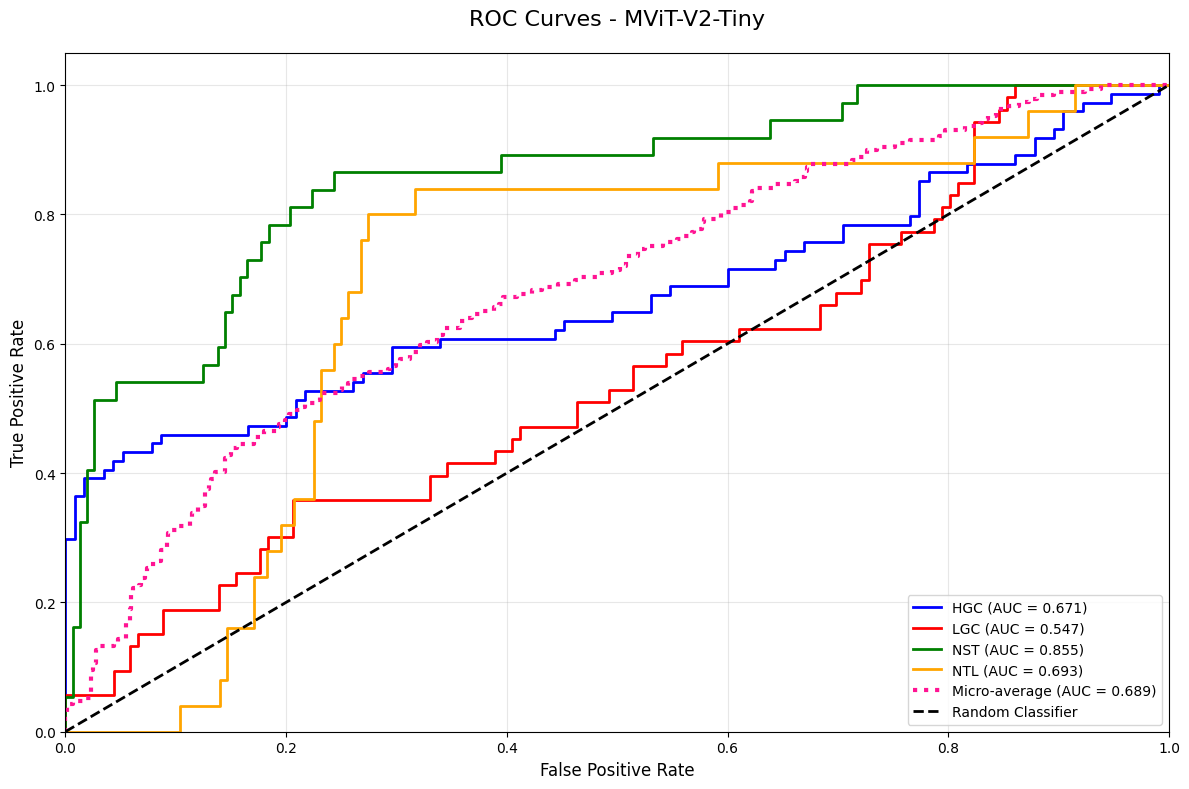


MViT v2 Tiny training and evaluation complete!


In [16]:
print("=" * 80)
print("Training MViT v2 Tiny")
print("=" * 80)

# Create model
mvit_tiny = create_mvit_model(architecture='mvitv2_tiny', num_classes=4, pretrained=True)

# Create trainer
trainer_mvit_tiny = ModelTrainer(mvit_tiny, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_mvit_tiny = trainer_mvit_tiny.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="MViT-V2-Tiny")

# Plot training history
trainer_mvit_tiny.plot_training_history(save_path='mvit_v2_tiny_training_history.png')

# Evaluate model
results_mvit_tiny = trainer_mvit_tiny.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_mvit_tiny['confusion_matrix'], class_names, 'MViT-V2-Tiny',
                      save_path='mvit_v2_tiny_confusion_matrix.png')

# Plot ROC curves
roc_auc_mvit_tiny = plot_roc_curves(results_mvit_tiny['labels'], results_mvit_tiny['probabilities'], class_names, 'MViT-V2-Tiny',
                                     save_path='mvit_v2_tiny_roc_curves.png')

# Store results
results_mvit_tiny['model_name'] = 'MViT-V2-Tiny'
results_mvit_tiny['roc_auc'] = roc_auc_mvit_tiny
all_results.append(results_mvit_tiny)

print("\nMViT v2 Tiny training and evaluation complete!")

## Train MViT v2 Base

Training MViT v2 Base


model.safetensors:   0%|          | 0.00/206M [00:00<?, ?B/s]

Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:27<00:00,  1.38it/s, Loss=1.3199, Acc=0.3569]


Train Loss: 1.3199 Acc: 0.3569 Macro-F1: 0.3228


Val : 100%|██████████| 10/10 [00:02<00:00,  3.80it/s, Loss=1.7776, Acc=0.3257]


Val Loss: 1.7776 Acc: 0.3257 Macro-F1: 0.2128
✓ New best model saved with validation macro-F1: 0.2128

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:27<00:00,  1.38it/s, Loss=1.2060, Acc=0.4416]


Train Loss: 1.2060 Acc: 0.4416 Macro-F1: 0.3957


Val : 100%|██████████| 10/10 [00:02<00:00,  3.82it/s, Loss=1.0634, Acc=0.4539]


Val Loss: 1.0634 Acc: 0.4539 Macro-F1: 0.3254
✓ New best model saved with validation macro-F1: 0.3254

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:27<00:00,  1.39it/s, Loss=1.1247, Acc=0.5288]


Train Loss: 1.1247 Acc: 0.5288 Macro-F1: 0.4364


Val : 100%|██████████| 10/10 [00:02<00:00,  3.79it/s, Loss=1.0753, Acc=0.5493]


Val Loss: 1.0753 Acc: 0.5493 Macro-F1: 0.4608
✓ New best model saved with validation macro-F1: 0.4608

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:27<00:00,  1.38it/s, Loss=1.1863, Acc=0.4737]


Train Loss: 1.1863 Acc: 0.4737 Macro-F1: 0.3870


Val : 100%|██████████| 10/10 [00:02<00:00,  3.78it/s, Loss=1.2484, Acc=0.4408]


Val Loss: 1.2484 Acc: 0.4408 Macro-F1: 0.3558

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:27<00:00,  1.38it/s, Loss=1.2203, Acc=0.4613]


Train Loss: 1.2203 Acc: 0.4613 Macro-F1: 0.3809


Val : 100%|██████████| 10/10 [00:02<00:00,  3.79it/s, Loss=1.1093, Acc=0.4836]


Val Loss: 1.1093 Acc: 0.4836 Macro-F1: 0.3395

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:27<00:00,  1.39it/s, Loss=1.2183, Acc=0.4589]


Train Loss: 1.2183 Acc: 0.4589 Macro-F1: 0.3908


Val : 100%|██████████| 10/10 [00:02<00:00,  3.80it/s, Loss=1.1021, Acc=0.4408]


Val Loss: 1.1021 Acc: 0.4408 Macro-F1: 0.3238

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:27<00:00,  1.38it/s, Loss=1.2283, Acc=0.3923]


Train Loss: 1.2283 Acc: 0.3923 Macro-F1: 0.3633


Val : 100%|██████████| 10/10 [00:02<00:00,  3.80it/s, Loss=1.2238, Acc=0.4178]


Val Loss: 1.2238 Acc: 0.4178 Macro-F1: 0.3429

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:27<00:00,  1.39it/s, Loss=1.1734, Acc=0.4186]


Train Loss: 1.1734 Acc: 0.4186 Macro-F1: 0.3267


Val : 100%|██████████| 10/10 [00:02<00:00,  3.84it/s, Loss=1.1011, Acc=0.4211]


Val Loss: 1.1011 Acc: 0.4211 Macro-F1: 0.3367
Early stopping triggered after 8 epochs
Training complete in 4m 2s
Best validation macro-F1: 0.4608


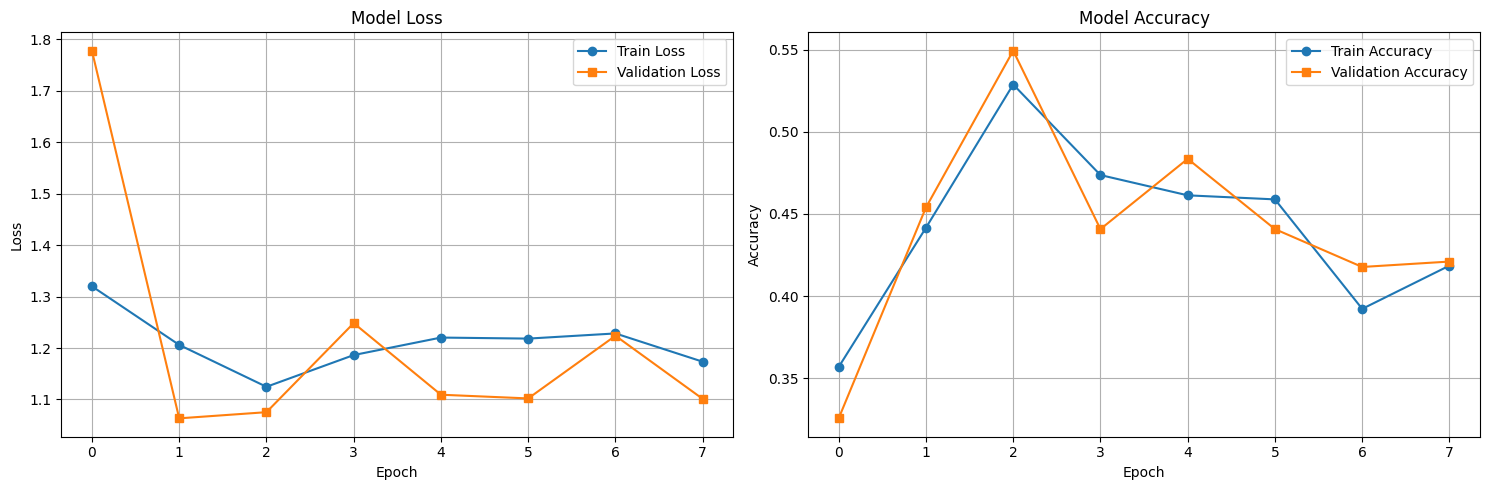

Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  3.31it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/us

Test Accuracy: 42.33%
Test Loss: 1.5105

Classification Report:
              precision    recall  f1-score   support

         HGC       0.00      0.00      0.00        74
         LGC       0.68      0.75      0.71        53
         NST       0.38      0.89      0.54        37
         NTL       0.16      0.28      0.20        25

    accuracy                           0.42       189
   macro avg       0.31      0.48      0.36       189
weighted avg       0.29      0.42      0.33       189


Confusion Matrix:
[[ 0 11 34 29]
 [ 0 40  8  5]
 [ 0  1 33  3]
 [ 0  7 11  7]]

ROC-AUC Scores:
Macro-average AUC: 0.6666
Micro-average AUC: 0.6279
HGC AUC: 0.4363
LGC AUC: 0.8488
NST AUC: 0.8704
NTL AUC: 0.5110


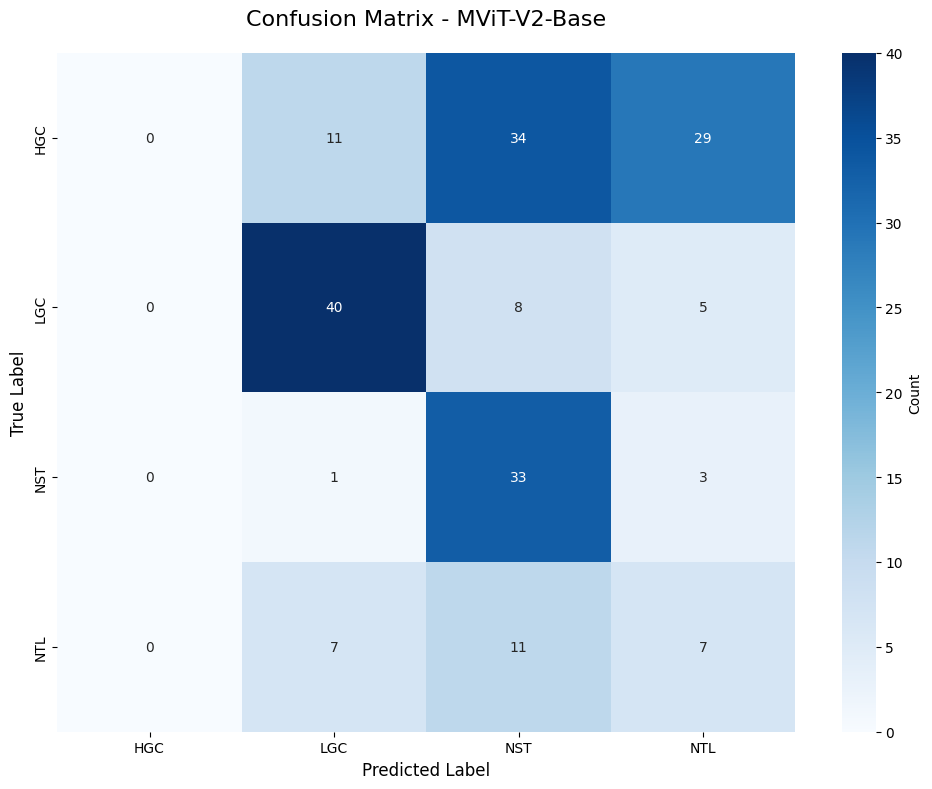

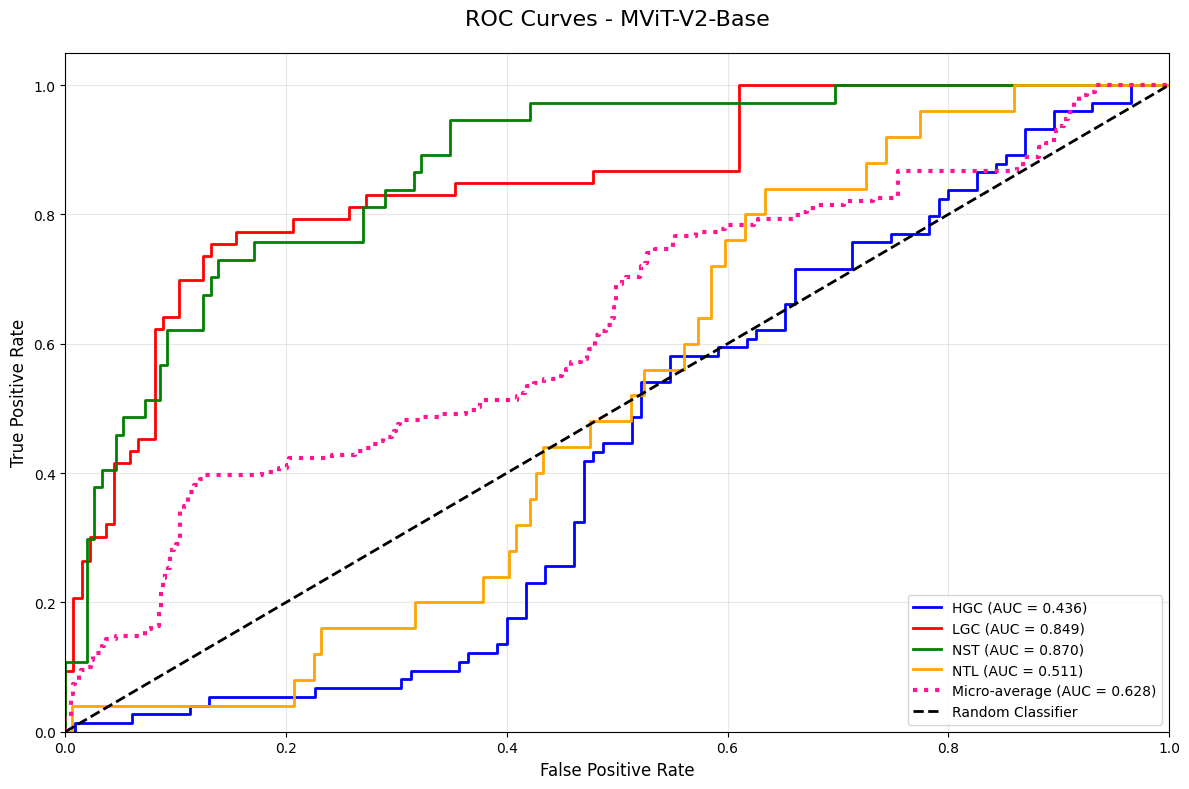


MViT v2 Base training and evaluation complete!


In [17]:
print("=" * 80)
print("Training MViT v2 Base")
print("=" * 80)

# Create model
mvit_base = create_mvit_model(architecture='mvitv2_base', num_classes=4, pretrained=True)

# Create trainer
trainer_mvit_base = ModelTrainer(mvit_base, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_mvit_base = trainer_mvit_base.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="MViT-V2-Base")

# Plot training history
trainer_mvit_base.plot_training_history(save_path='mvit_v2_base_training_history.png')

# Evaluate model
results_mvit_base = trainer_mvit_base.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_mvit_base['confusion_matrix'], class_names, 'MViT-V2-Base',
                      save_path='mvit_v2_base_confusion_matrix.png')

# Plot ROC curves
roc_auc_mvit_base = plot_roc_curves(results_mvit_base['labels'], results_mvit_base['probabilities'], class_names, 'MViT-V2-Base',
                                     save_path='mvit_v2_base_roc_curves.png')

# Store results
results_mvit_base['model_name'] = 'MViT-V2-Base'
results_mvit_base['roc_auc'] = roc_auc_mvit_base
all_results.append(results_mvit_base)

print("\nMViT v2 Base training and evaluation complete!")

## Train MViT v2 Small

Training MViT v2 Small


model.safetensors:   0%|          | 0.00/140M [00:00<?, ?B/s]

Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.96it/s, Loss=1.4079, Acc=0.2327]


Train Loss: 1.4079 Acc: 0.2327 Macro-F1: 0.2243


Val : 100%|██████████| 10/10 [00:02<00:00,  4.98it/s, Loss=1.3412, Acc=0.3684]


Val Loss: 1.3412 Acc: 0.3684 Macro-F1: 0.1346
✓ New best model saved with validation macro-F1: 0.1346

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.95it/s, Loss=1.3992, Acc=0.2977]


Train Loss: 1.3992 Acc: 0.2977 Macro-F1: 0.2729


Val : 100%|██████████| 10/10 [00:02<00:00,  4.98it/s, Loss=1.4471, Acc=0.2796]


Val Loss: 1.4471 Acc: 0.2796 Macro-F1: 0.1130

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.97it/s, Loss=1.3658, Acc=0.3956]


Train Loss: 1.3658 Acc: 0.3956 Macro-F1: 0.3154


Val : 100%|██████████| 10/10 [00:02<00:00,  4.99it/s, Loss=1.2093, Acc=0.5526]


Val Loss: 1.2093 Acc: 0.5526 Macro-F1: 0.4108
✓ New best model saved with validation macro-F1: 0.4108

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.96it/s, Loss=1.2788, Acc=0.4334]


Train Loss: 1.2788 Acc: 0.4334 Macro-F1: 0.3680


Val : 100%|██████████| 10/10 [00:02<00:00,  4.95it/s, Loss=1.1358, Acc=0.6053]


Val Loss: 1.1358 Acc: 0.6053 Macro-F1: 0.4665
✓ New best model saved with validation macro-F1: 0.4665

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.96it/s, Loss=1.2700, Acc=0.4934]


Train Loss: 1.2700 Acc: 0.4934 Macro-F1: 0.4032


Val : 100%|██████████| 10/10 [00:02<00:00,  4.95it/s, Loss=1.2006, Acc=0.2928]


Val Loss: 1.2006 Acc: 0.2928 Macro-F1: 0.2441

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.96it/s, Loss=1.3243, Acc=0.3824]


Train Loss: 1.3243 Acc: 0.3824 Macro-F1: 0.3228


Val : 100%|██████████| 10/10 [00:01<00:00,  5.01it/s, Loss=1.2844, Acc=0.4178]


Val Loss: 1.2844 Acc: 0.4178 Macro-F1: 0.2903

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.96it/s, Loss=1.2369, Acc=0.5378]


Train Loss: 1.2369 Acc: 0.5378 Macro-F1: 0.4210


Val : 100%|██████████| 10/10 [00:02<00:00,  5.00it/s, Loss=1.1593, Acc=0.4934]


Val Loss: 1.1593 Acc: 0.4934 Macro-F1: 0.3687

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.96it/s, Loss=1.1857, Acc=0.5370]


Train Loss: 1.1857 Acc: 0.5370 Macro-F1: 0.4070


Val : 100%|██████████| 10/10 [00:02<00:00,  4.96it/s, Loss=1.1359, Acc=0.5428]


Val Loss: 1.1359 Acc: 0.5428 Macro-F1: 0.4484

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.96it/s, Loss=1.1594, Acc=0.5609]


Train Loss: 1.1594 Acc: 0.5609 Macro-F1: 0.4398


Val : 100%|██████████| 10/10 [00:02<00:00,  4.93it/s, Loss=1.1180, Acc=0.5493]


Val Loss: 1.1180 Acc: 0.5493 Macro-F1: 0.4178
Early stopping triggered after 9 epochs
Training complete in 3m 14s
Best validation macro-F1: 0.4665


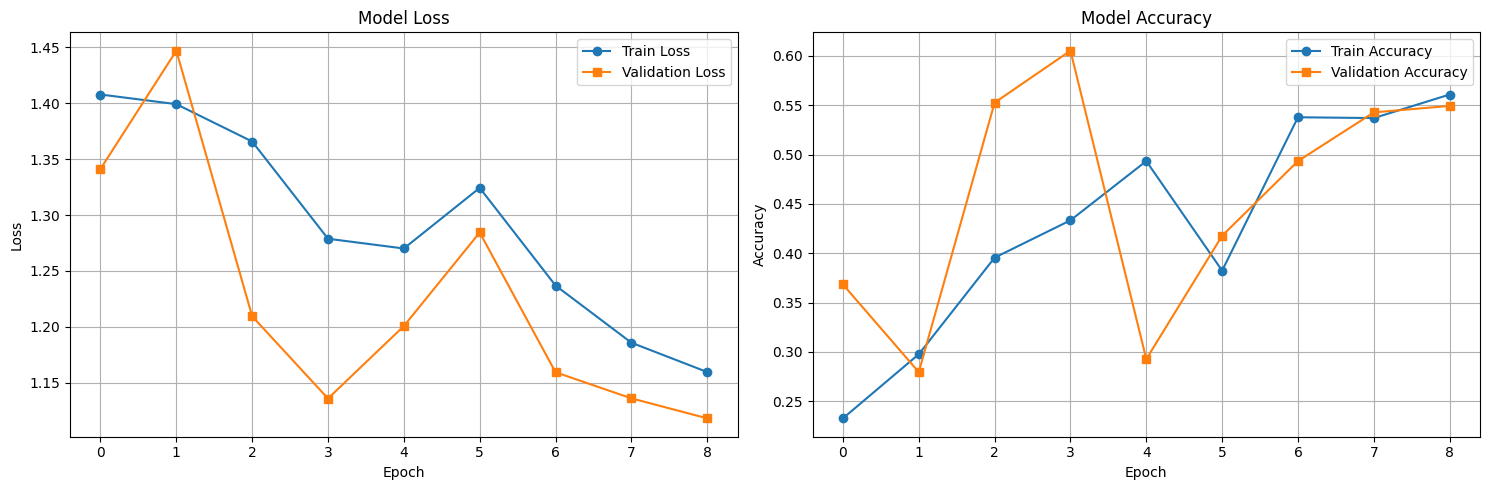

Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  4.19it/s]


Test Accuracy: 36.51%
Test Loss: 1.3480

Classification Report:
              precision    recall  f1-score   support

         HGC       0.35      0.27      0.31        74
         LGC       0.37      0.30      0.33        53
         NST       0.38      0.89      0.53        37
         NTL       0.00      0.00      0.00        25

    accuracy                           0.37       189
   macro avg       0.27      0.37      0.29       189
weighted avg       0.32      0.37      0.32       189


Confusion Matrix:
[[20 20 34  0]
 [24 16 12  1]
 [ 1  3 33  0]
 [12  4  9  0]]

ROC-AUC Scores:
Macro-average AUC: 0.6118
Micro-average AUC: 0.6122
HGC AUC: 0.4224
LGC AUC: 0.6762
NST AUC: 0.7833
NTL AUC: 0.5654


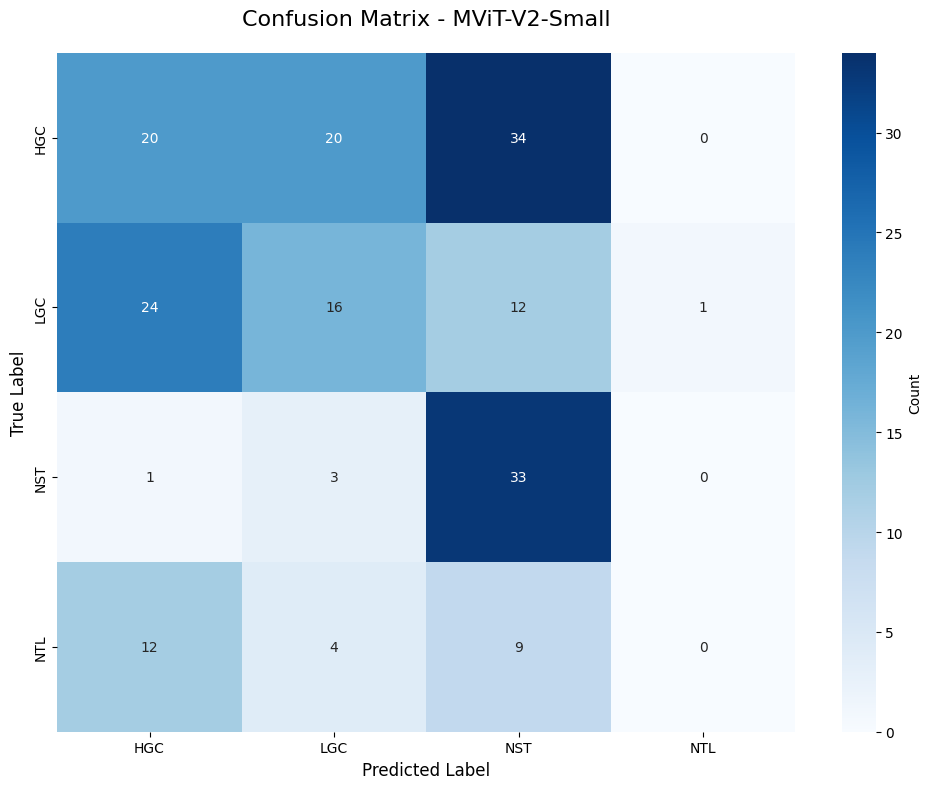

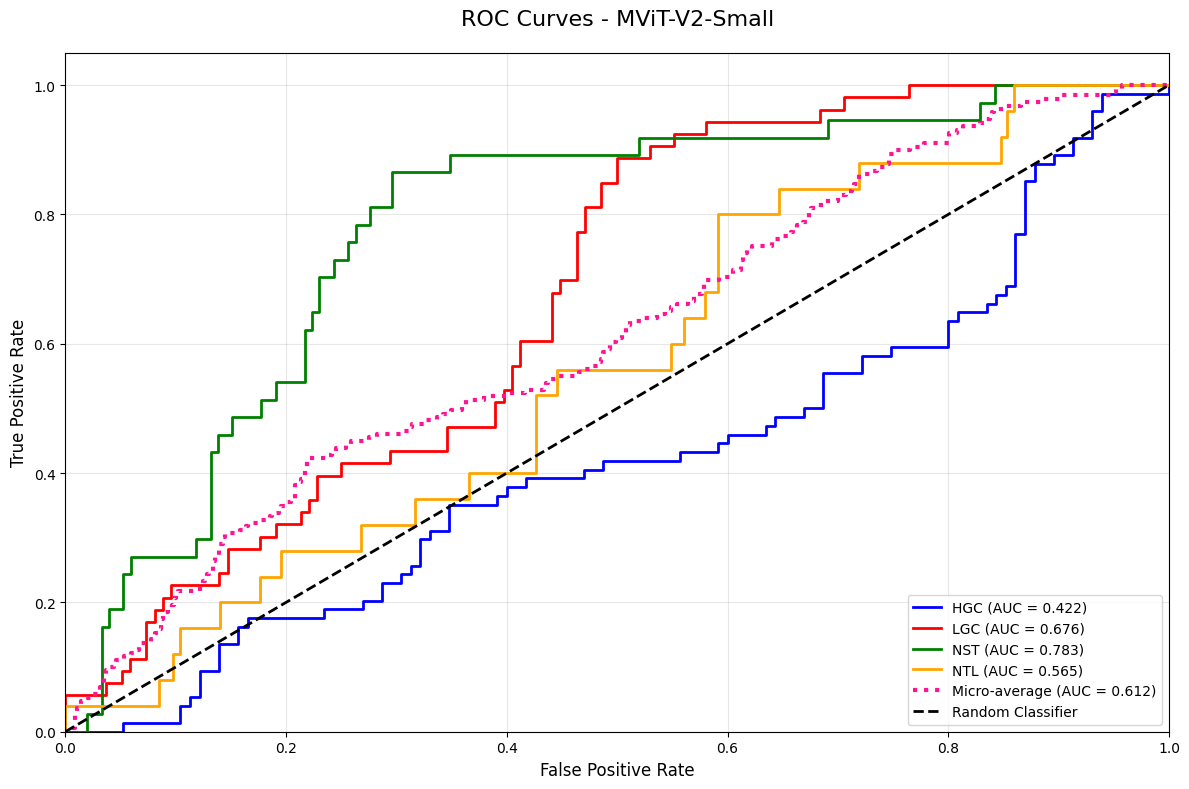


MViT v2 Small training and evaluation complete!


In [18]:
print("=" * 80)
print("Training MViT v2 Small")
print("=" * 80)

# Create model
mvit_small = create_mvit_model(architecture='mvitv2_small', num_classes=4, pretrained=True)

# Create trainer
trainer_mvit_small = ModelTrainer(mvit_small, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_mvit_small = trainer_mvit_small.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="MViT-V2-Small")

# Plot training history
trainer_mvit_small.plot_training_history(save_path='mvit_v2_small_training_history.png')

# Evaluate model
results_mvit_small = trainer_mvit_small.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_mvit_small['confusion_matrix'], class_names, 'MViT-V2-Small',
                      save_path='mvit_v2_small_confusion_matrix.png')

# Plot ROC curves
roc_auc_mvit_small = plot_roc_curves(results_mvit_small['labels'], results_mvit_small['probabilities'], class_names, 'MViT-V2-Small',
                                     save_path='mvit_v2_small_roc_curves.png')

# Store results
results_mvit_small['model_name'] = 'MViT-V2-Small'
results_mvit_small['roc_auc'] = roc_auc_mvit_small
all_results.append(results_mvit_small)

print("\nMViT v2 Small training and evaluation complete!")

# Save All Metrics to CSV

In [19]:
# Prepare data for CSV
metrics_data = []

for result in all_results:
    model_name = result['model_name']
    report = result['classification_report']
    
    # Overall metrics
    row = {
        'Model': model_name,
        'Overall_Accuracy': result['accuracy'],
        'Overall_Loss': result['loss'],
        'Macro_Avg_Precision': report['macro avg']['precision'],
        'Macro_Avg_Recall': report['macro avg']['recall'],
        'Macro_Avg_F1': report['macro avg']['f1-score'],
        'Weighted_Avg_Precision': report['weighted avg']['precision'],
        'Weighted_Avg_Recall': report['weighted avg']['recall'],
        'Weighted_Avg_F1': report['weighted avg']['f1-score'],
    }
    
    # Per-class metrics
    for class_name in class_names:
        row[f'{class_name}_Precision'] = report[class_name]['precision']
        row[f'{class_name}_Recall'] = report[class_name]['recall']
        row[f'{class_name}_F1'] = report[class_name]['f1-score']
        row[f'{class_name}_Support'] = report[class_name]['support']
    
    # ROC-AUC scores
    row['Macro_AUC'] = result['macro_auc']
    row['Micro_AUC'] = result['micro_auc']
    for class_name in class_names:
        row[f'{class_name}_AUC'] = result['per_class_auc'][class_name]
    
    # Also store ROC-AUC from plot_roc_curves if available
    if 'roc_auc' in result:
        for i, class_name in enumerate(class_names):
            row[f'{class_name}_Plot_AUC'] = result['roc_auc'][i]
        row['Micro_Avg_Plot_AUC'] = result['roc_auc']['micro']
    
    metrics_data.append(row)

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Save to CSV
csv_path = 'MViT_V2_metrics.csv'
metrics_df.to_csv(csv_path, index=False)

print(f"\nMetrics saved to: {csv_path}")
print("\nMetrics Summary:")
print(metrics_df.to_string())


Metrics saved to: MViT_V2_metrics.csv

Metrics Summary:
           Model  Overall_Accuracy  Overall_Loss  Macro_Avg_Precision  Macro_Avg_Recall  Macro_Avg_F1  Weighted_Avg_Precision  Weighted_Avg_Recall  Weighted_Avg_F1  HGC_Precision  HGC_Recall    HGC_F1  HGC_Support  LGC_Precision  LGC_Recall    LGC_F1  LGC_Support  NST_Precision  NST_Recall    NST_F1  NST_Support  NTL_Precision  NTL_Recall    NTL_F1  NTL_Support  Macro_AUC  Micro_AUC   HGC_AUC   LGC_AUC   NST_AUC   NTL_AUC  HGC_Plot_AUC  LGC_Plot_AUC  NST_Plot_AUC  NTL_Plot_AUC  Micro_Avg_Plot_AUC
0   MViT-V2-Tiny         46.560847      3.202226             0.508590          0.509488      0.467679                0.577889             0.465608         0.480053       0.861111    0.418919  0.563636         74.0       0.351852    0.358491  0.355140         53.0       0.526316    0.540541  0.533333         37.0       0.295082        0.72  0.418605         25.0   0.691444   0.688773  0.670975  0.547031  0.855085  0.692683      0.670975  